## Goal is to choose the regression model with BEST performance metrics

### Choose from Simple Linear, Polynomial, Ridge or Lasso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Advertising.csv')
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


<Axes: xlabel='newspaper', ylabel='sales'>

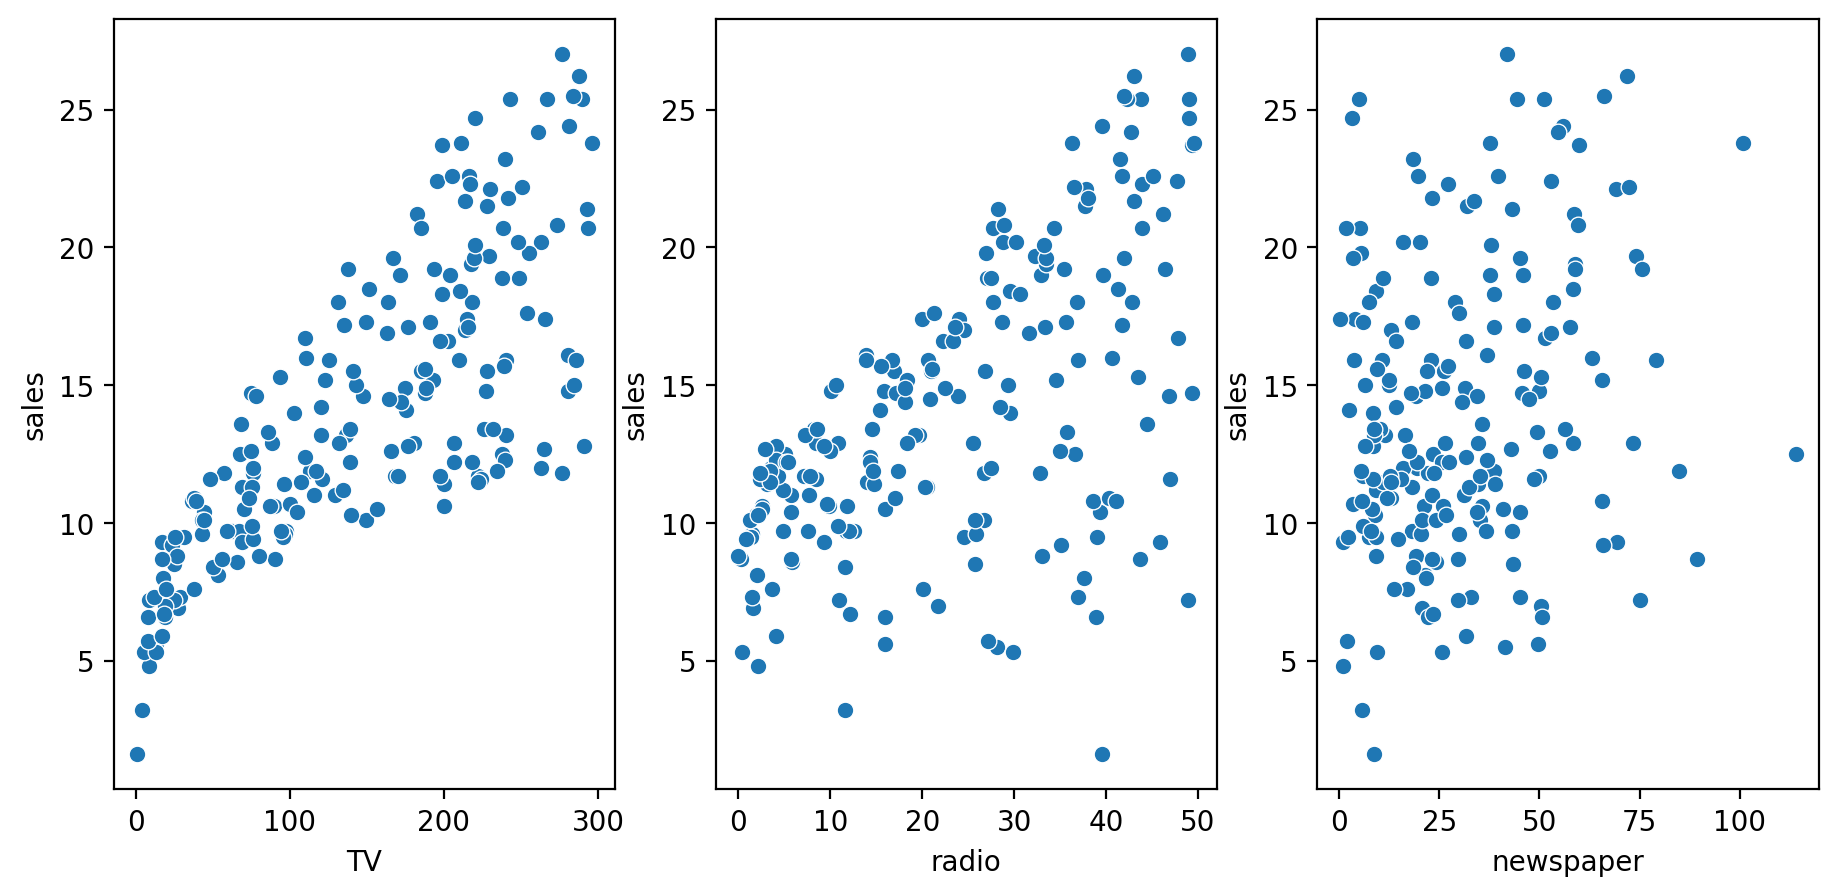

In [2]:
fig, axes = plt.subplots(1, 3, figsize=(11,5), dpi=200)

sns.scatterplot(data=df, x='TV', y='sales', ax=axes[0])
sns.scatterplot(data=df, x='radio', y='sales', ax=axes[1])
sns.scatterplot(data=df, x='newspaper', y='sales', ax=axes[2])

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('sales', axis=1)
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Simple Linear Regression

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)

MSE = mean_squared_error(y_test,test_predictions)
RMSE_simple = np.sqrt(MSE)
RMSE_simple

1.9485372043446387

In [5]:
df['sales'].mean()

14.0225

In [6]:
percent_distance_from_the_mean = (RMSE_simple/df['sales'].mean()) * 100
percent_distance_from_the_mean 

13.8957903679418

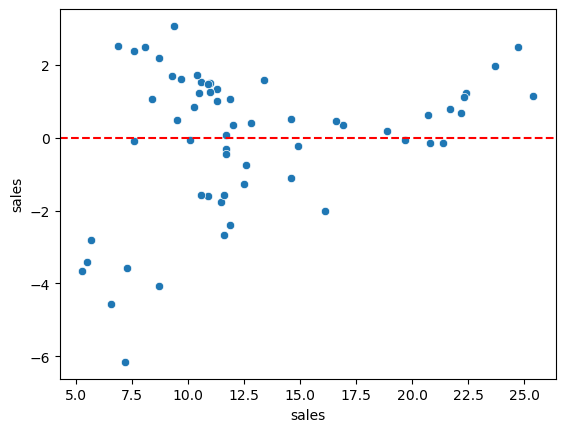

In [7]:
residuals = y_test - test_predictions
sns.scatterplot(x=y_test,y=residuals)
plt.axhline(y=0, color='r', linestyle='--')

In [8]:
model.coef_

array([3.68334078, 2.90625242, 0.14194772])

In [9]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
TV,3.683341
radio,2.906252
newspaper,0.141948


### Polynomial Regression - Determine Appropriate Complexity

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Choose the best complexity while considering potential underfitting/overfitting
# Plot complexity (n) vs RMSE for Training Results
# Plot complexity (n) vs RMSE for Testing Results

train_rmse_errors = []
test_rmse_errors = []
for d in range(1,10):
    
      # CREATE POLY DATA SET FOR DEGREE "d"
    polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
    poly_features = polynomial_converter.fit_transform(X)
    
    # SPLIT THIS NEW POLY DATA SET
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)
    
    # Scaling Process
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # TRAIN ON THIS NEW POLY SET
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train,y_train)
    
    # PREDICT ON BOTH TRAIN AND TEST
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Calculate Errors
    
    # Errors on Train Set
    train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
    
    # Errors on Test Set
    test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

    # Append errors to lists for plotting later
    
   
    train_rmse_errors.append(train_RMSE)
    test_rmse_errors.append(test_RMSE)


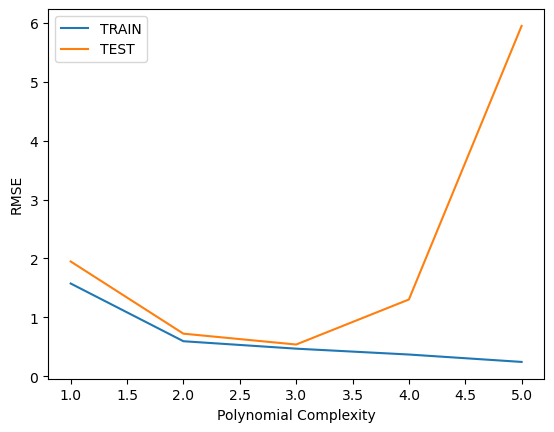

In [11]:
plt.plot(range(1,6),train_rmse_errors[:5],label='TRAIN')
plt.plot(range(1,6),test_rmse_errors[:5],label='TEST')
plt.xlabel("Polynomial Complexity")
plt.ylabel("RMSE")
plt.legend()

- From the chart above, I can choose complexity = 2 or 3. Anything sporadically increases the variance and causes overfitting.
- I will stick to 3. 

In [12]:
polynomial_converter = PolynomialFeatures(degree=3,include_bias=False)
poly_features = polynomial_converter.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)

MSE = mean_squared_error(y_test,test_predictions)
RMSE_polynomial = np.sqrt(MSE)
RMSE_polynomial


0.5392350985651533

In [13]:
percent_distance_from_the_mean = (RMSE_polynomial/df['sales'].mean()) * 100
percent_distance_from_the_mean 

3.845499009200594

In [14]:
model.coef_

array([  7.84366819,   0.13651919,   0.54890589, -11.39681606,
         4.72402877,  -1.62648796,   0.15821632,   0.23748062,
         0.19273882,   5.31803549,  -0.7840641 ,   1.42833862,
        -0.02043239,  -0.56045886,   0.01839503,  -0.11686019,
         0.13857697,  -0.10387791,  -0.19010043])

### Ridge - Adding a penalty term to shrink large coefficients

In [15]:
# Choose the alpha value with the aid of built-in Cross Validation
from sklearn.linear_model import RidgeCV
ridge_cv_model = RidgeCV(alphas=(0.1, 1.0, 10.0),scoring='neg_mean_absolute_error')
ridge_cv_model.fit(X_train,y_train)
ridge_cv_model.alpha_

0.1

In [16]:
test_predictions = ridge_cv_model.predict(X_test)
MSE = mean_squared_error(y_test,test_predictions)
RMSE_ridge = np.sqrt(MSE)
RMSE_ridge

0.5945136671806206

In [17]:
percent_distance_from_the_mean = (RMSE_ridge/df['sales'].mean()) * 100
percent_distance_from_the_mean 

4.239712370694388

In [18]:
ridge_cv_model.coef_

array([ 5.90523815,  0.46316396,  0.68028713, -6.17743395,  3.73671928,
       -1.40708382,  0.00624704,  0.11128917, -0.2617823 ,  2.17135744,
       -0.51480159,  0.70587211,  0.60311504, -0.53271216,  0.5716495 ,
       -0.34685826,  0.36744388, -0.03938079, -0.12192939])

### Lasso

In [19]:
from sklearn.linear_model import LassoCV
lasso_cv_model = LassoCV(eps=0.1,n_alphas=100,cv=5)
lasso_cv_model.fit(X_train,y_train)
lasso_cv_model.alpha_

0.4924531806474871

In [20]:
test_predictions = lasso_cv_model.predict(X_test)
MSE = mean_squared_error(y_test,test_predictions)
RMSE_Lasso = np.sqrt(MSE)
RMSE_Lasso

1.0349127365478727

In [21]:
percent_distance_from_the_mean = (RMSE_Lasso/df['sales'].mean()) * 100
percent_distance_from_the_mean 

7.380372519507025

In [22]:
lasso_cv_model.coef_

array([0.97675148, 0.        , 0.        , 0.        , 3.8148913 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### Summary

<Axes: title={'center': 'Performance Metrics'}, xlabel='Regression Types', ylabel='RMSE'>

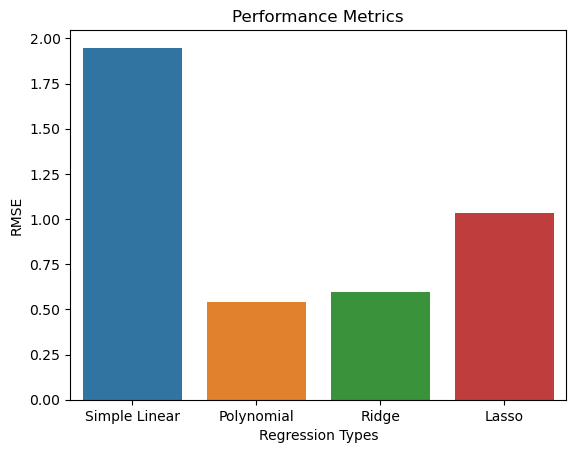

In [23]:
categories = ['Simple Linear', 'Polynomial', 'Ridge', 'Lasso']
values = [RMSE_simple, RMSE_polynomial, RMSE_ridge, RMSE_Lasso]

plt.title('Performance Metrics')
plt.ylabel('RMSE')
plt.xlabel('Regression Types')
sns.barplot(x=categories, y=values)

- Simple Linear: the worst performance of them all with the RMSE being equal to 1.9485372043446387 which is 13.8957903679418 percent from the mean 14.0225. 
- Polynomial/Ridge: somewhat similar performances. the polynomial did have the lowest residual error of them all, but I strongly believe that if further trial/error was performed for the Ridge's alpha values (affecting the penalty term), the Ridge model could have achieved better results. Polynomial RMSE: 0.5392350985651533 & Ridge: 0.5945136671806206. The polynomial model's complexity must not go any higher based on underfitting/overfitting investigation performed. A complexity of 3 is the absolute maximum. 
- Lasso: Lasso did not perform as well as the Polynomial/Ridge models with a RMSE of 1.0349127365478727. However, this weaker performance comes with the benefit of shrinking most feature coefficients to 0. If an error 7.380372519507025 % is acceptable, the lasso model is the simplest of them all. 